## Problem Statement

![alt text](../img/assignment.png "Title")
This problem requires to create a network which can take two types of input 
1. MNIST image
2. A random Number from 0-9

and then give out two outputs 
1. MNIST label corresponding to the input image
2. Sum of input random number and MNIST label


e.g if MNIST image is 5 and input random number is 6 then the output will be 5 & 11


The solution is in this notebook

---


## Import the dependencies

In [1]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import warnings
import torch.utils.data as data
from PIL import Image
import os
import os.path
import codecs
import random
## for tensorboard
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets.utils import download_url
from numpy.random import seed
from numpy.random import randint
import gzip
import errno
seed(1)

torch.set_printoptions(linewidth=120)


## Enable the gradient calculations.
It will be enabled by default but just in case if it is not there. Its a good practice to do that

In [2]:
torch.set_grad_enabled(True)


## Utiiliy functions

These are the helper functions used in the code

In [3]:
## These are the functions that will be used to calculate the accuracy of the network
##They basically compares the predictions with the target values. Find out how many are matching and gives the number

def get_num_correct_MNISTLabels(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

def get_num_correct_sumLabels(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()


In [4]:
## this is a plotting function that is used to draw a batch of MNIST images.
## they will be shown in a grid of 10 images in a row
def plotGridImages(images,labels):
   
    grid=torchvision.utils.make_grid(images,nrow=10)
    plt.figure(figsize=(15,15))
    plt.title('MNIST Image Grid')
    plt.imshow(np.transpose(grid,(1,2,0)))
    print("MNIST Labels=>",labels)

## Network Architecture

![alt text](../img/network_architecture.png "Title")


The various Layers and the size values are:

**Conv1** : (6 kernel of $5*5$) , Activation RELU, _Input:_  $1*28*28$ _Output:_ $6*24*24$

**Maxpool1:** __Output__ : $6*12*12$

**Conv2**: (12 kernels of $5*5$) ,Activation RELU , _Input:_ $6*12*12$  _Output:_ $12*8*8$


**Maxpool2:**  _Output:_ $12*4*4$


**Flatten:** Output: 1-D tensor of size 192 

**FC1**:Activation RELU _Input:_ 192 _Output:_ 120

**1-hot vector:** Digit converted to 10 length tensor

**FC2:** Activation RELU , _Input:_ 10 _Output:_ 20

**Concatenate:** Combine tensors of 120 and 20 to give tensor of 140

**FC3**:Activation RELU , _Input:_ 140 _Output:_ 100

**Output Layer**: No Activation , _Input_:100 _Output:_ 29




### Some important points to note about the architecture


1. There are 2 inputs and 2 outputs since the network is supposed to take a MNIST image and a integer number and give out MNIST label and the sum of MNIST label and the input number




2. For the MNIST identification we have the Convolution network. Once the image has been flattened and pass through __FC1__ it becomes a regular 1-D input which is then _concatenated_ with the __FC2__ output (representing the random number) 

3. The MNIST data tensor and the RandomNumber tensor gets concatenated before FC3. 
MNIST data at this point is of size 120 and random number tensor is of size 20
FC3 therefor takes input of size 140 and then gives out  output of size 100 


4. Once combined they are passed through __FC3__ and then to the output layer

5. The output layer is special. It is of dimension 19 where first 10 neurons represents the MNIST label and the next 19 neurons represents the sum 


### Output Layer

![alt text](../img/output_layer.png "Title")



* The output layer has 2 parts the __Red__ part (top10 neurons) are for the __MNIST__ output. Basically if 4 was the input and the Network is trained properly then it will have a 1 in the 5th position (the number starts from 0). 

* Similarly the lower part which is in green will highlight the bit corresponding to the sum of 6+4=10


This problem can be considered as a __2 set of Mutliclass classification problem__. The 2 set of classes are 
1. **The MNIST labels** $\Rightarrow$ These labels correspond to the MNIST images and are part of the MNIST dataset
2. **The Sum labels**  $\Rightarrow $ The summation value that the network is generating can be considered as the classes. The possible such classes will be 0-18. (MNIST highest value is 9 and random number highest value is also 9). We can treat these labels similar to the MNIST labels



In [5]:
## A network class has been defined for the architecture as discussed above

class NetworkMIP(nn.Module):
    def __init__(self):
        
        ##calling the superclass. the base class will keep the track of weights
        super(NetworkMIP,self).__init__()
        
        ## Convolution Layers
        self.conv1=nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5) #1∗28∗28  >> 6*24*24
        self.conv2=nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5) #6*12*12 >> 12*8*8
         
        ##Fully Connected Layers
        self.fc1=nn.Linear(in_features=12*4*4,out_features=120) # 192 >>120
        self.fc2=nn.Linear(in_features=10,out_features=20) # 10 >> 20
        self.fc3=nn.Linear(in_features=140,out_features=100) #140 >> 100
        
        ## Output layer
        self.out=nn.Linear(in_features=100,out_features=29) # 100 >>29
    
     
    ## this is the feed forward function that gets called when we all the instance of the class
    ## it takes 2 inputs 
    ## 1. MNIST Image Tensor
    ## 2. The random Number Tensor
    def forward(self,imgT,numT):
        # conv1
        imgT=self.conv1(imgT) #28*28 >> 6*24*24
        imgT=F.relu(imgT) # RELU activation
        imgT=F.max_pool2d(imgT,kernel_size=2,stride=2) #6*24*24 >> 6*12*12
        
        #conv2
        imgT=self.conv2(imgT)# >>6*12*12  >> 12*8*8
        imgT=F.relu(imgT)# RELU activation
        imgT=F.max_pool2d(imgT,kernel_size=2,stride=2) #12*8*8>> 12*4*4
        
        #before passing to FC1 we need to flatten
        imgT=imgT.reshape(-1,12*4*4)
        
        #passing to FC1
        imgT=self.fc1(imgT) ##192>>120
        imgT=F.relu(imgT) # RELU activation
        
        
        ## now adding the number to the fc2
        numT=self.fc2(numT)## 10>>20
        numT=F.relu(numT) # RELU activation
        
        ##concatenating the two tensors img+num
        t = torch.cat((imgT, numT), dim=1)  #120+20=140
        
        ## passing through fc3 to reduce the size
        t=self.fc3(t)##140>>100
        t=F.relu(t) # RELU activation
        
        #output layer
        t=self.out(t)##100>>29   
        return t
    

## Dataset class

The basic Idea behind the design:


We need two set of inputs:
1.  MNIST images which are 28*28 pixels in size 
2.  Random Numbers from 0-9 (Integers). 

The MNIST data is available online and comes with images and corresponding labels.

Now for the random number part we had to create our own data. Like MNIST there are two parts to it:

1. Random number 
2. SumLabels : The sum of random number and the MNIST label

Eg. 
MNIST = 5 , randNum=6 , sumLabel=11

MNIST = 3, randNum=2 , sumLabel=5

And so on 


###  Random Number Generation
The random number is generated using **randint()** in the ```__getItem__``` method



### SumLabels Generation
The sum of the MNIST label and the random number is generated in the ```__getItem__``` method. This is explained below



![alt text](../img/approach2.png "Title")

We do the following

1. Take the MNIST at index ```idx``` so ```MNISTImages[idx]```
2. Take the corresponding Label $\Rightarrow$ ```MNISTLabels[idx]```
3. Generate a random number using the randint(0,9) method $\Rightarrow$ ```inputRand= random.randint(0,9)```
4. Calculate the sum of MNISTLabel and RandomNumber $\Rightarrow$ ```MNISTLabels[idx]+inputRand``

5. Convert ```inputRand``` to 1-hot representation
6. Return a dictionary of 
```
 return {
            "inputs":{
                    "mnistImage":MNISTImg, ## the MNIST Image
                    "randomNumberTensor":tensorInputRand ## Random Number in 1-hot encoding
                    },
            "outputs":{
                    "mnistLabel":MNISTLabel, ## Lable for MNIST image
                    "sumLabelTensor":tensorSumLabel ## the sum of MNIST Label and random number
                    }
            }
 ```


In [6]:

## this is a custom dataset class. The design is inspired by pytorch (the MNIST dataset class)
## 3 functions are mandatory
## 1. __init__ : initialization
## 2. __getitem__: this is needed for iterating the dataset
## 3. __len__: to get the size of the dataset

class MultiInputDataSet(data.Dataset):
   
    ## the file names as defined in the MNIST dataset. the class will be able to generate train as well as test dataset 
    urls = [
        'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
    ]
  
    
    training_file = 'training.pt'
    test_file = 'test.pt'
    classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
    
    ## the init function takes
    ##1. root: the path where MNIST data is stored. the assumption is that is already downloaded in a local directory
    ##2. train: boolean to specify if train data is needed or test data is needed
    ##3. transform: any kind of transformation required on the data. This is mainly for the MNIST images as of now
    def __init__(self, root, train=True,download=True,transform=None):
        self.root = root
        self.transform = transform
        self.train = train  # training set or test set
        
        if download:
            self.download()
        
        
        ##train or test data based on the boolean . Training set will give 60K imagaes
        ## test data will be 10K images
        if self.train:
            data_file = self.training_file ## file to pull trainign MNIST images
        else:
            data_file = self.test_file ##file to pull test MNIST images
        
        self.MNISTImages, self.MNISTMNISTLabels = torch.load(os.path.join(self.processed_folder, data_file))
   
       
    ## __getitem__ is a  mandatory function for iterating the data
    ## it is doing multiple things as descibed in the notes above. => finding the MNIST image, MNISTLabel, random number, sumMNISTLabel at a particular index
    
    def __getitem__(self, idx):        
        
        ##1. get the MNIST image & the MNISTLabel
        MNISTImg, MNISTLabel = self.MNISTImages[idx], int(self.MNISTMNISTLabels[idx])
        MNISTImg = Image.fromarray(MNISTImg.numpy(), mode='L')
        
        ##2. perform transformation if any
        if self.transform is not None:
            MNISTImg = self.transform(MNISTImg)

        #processing of the random number
        ##1. get the input number
        inputRand= random.randint(0,9)
        
        ##2. convert to 1-hot encoding with class 10 also convert to tensor
        tensorInputRand=F.one_hot(torch.tensor(inputRand), num_classes=10)
        
        ##3. 1-hot encoding will give you integer values but neural network needs floating points so convert them
        tensorInputRand=tensorInputRand.type(torch.FloatTensor)
        
        ##4. Set the sumLabel as MNISTLabel+random number.
        sumLabel=MNISTLabel+inputRand
        tensorSumLabel=torch.tensor(sumLabel)
        
        #Output: we are returing a dictioary of inputs and outputs
        return {
            "inputs":{
                    "mnistImage":MNISTImg,## the MNIST Image
                    "randomNumberTensor":tensorInputRand ## Random Number in 1-hot encoding
                    },
            "outputs":{
                    "mnistLabel":MNISTLabel, ## Lable for MNIST image
                    "sumLabelTensor":tensorSumLabel ## the sum of MNIST Label and random number
                    }
            }

    
    ##Length can be just the size of the MNIST images.all the datapoints are symmetrical in shape so we can return 
    ## the length of any of the 4 MNIST images, MNIST labels, Random Numbers, Sum Labels
    def __len__(self):
        return len(self.MNISTImages)

   
    '''
    Following code is for the download to happen
    '''

    def _check_exists(self):
        return os.path.exists(os.path.join(self.processed_folder, self.training_file)) and \
            os.path.exists(os.path.join(self.processed_folder, self.test_file))

    
    def _makedir_exist_ok(self,dirpath):
        try:
            os.makedirs(dirpath)
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

                
    @staticmethod
    def extract_gzip(gzip_path, remove_finished=False):
        print('Extracting {}'.format(gzip_path))
        with open(gzip_path.replace('.gz', ''), 'wb') as out_f, \
                gzip.GzipFile(gzip_path) as zip_f:
            out_f.write(zip_f.read())
        if remove_finished:
            os.unlink(gzip_path)
            
            
    
    
    
    @property
    def raw_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'raw')

    @property
    def processed_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'processed')
    
    
    
    def download(self):
        """Download the MNIST data if it doesn't exist in processed_folder already."""

        if self._check_exists():
            return

        self._makedir_exist_ok(self.raw_folder)
        self._makedir_exist_ok(self.processed_folder)

        # download files
        for url in self.urls:
            filename = url.rpartition('/')[2]
            file_path = os.path.join(self.raw_folder, filename)
            download_url(url, root=self.raw_folder, filename=filename, md5=None)
            self.extract_gzip(gzip_path=file_path, remove_finished=True)

        # process and save as torch files
        print('Processing...')

        training_set = (
            self.read_image_file(os.path.join(self.raw_folder, 'train-images-idx3-ubyte')),
            self.read_label_file(os.path.join(self.raw_folder, 'train-labels-idx1-ubyte'))
        )
        test_set = (
            self.read_image_file(os.path.join(self.raw_folder, 't10k-images-idx3-ubyte')),
            self.read_label_file(os.path.join(self.raw_folder, 't10k-labels-idx1-ubyte'))
        )
        with open(os.path.join(self.processed_folder, self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(self.processed_folder, self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('Done!')

    def read_image_file(self,path):
        with open(path, 'rb') as f:
            data = f.read()
            assert self.get_int(data[:4]) == 2051
            length = self.get_int(data[4:8])
            num_rows = self.get_int(data[8:12])
            num_cols = self.get_int(data[12:16])
            parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
            return torch.from_numpy(parsed).view(length, num_rows, num_cols)

    def read_label_file(self,path):
        with open(path, 'rb') as f:
            data = f.read()
            assert self.get_int(data[:4]) == 2049
            length = self.get_int(data[4:8])
            parsed = np.frombuffer(data, dtype=np.uint8, offset=8)
            return torch.from_numpy(parsed).view(length).long()

    def get_int(self,b):
        return int(codecs.encode(b, 'hex'), 16)


## Validate Train & Test Datasets

We can check if the data is coming properly by loading 1 batch of images

We make use of dataloader class to do so. The dataloader will load batch of data using the Dataset that we provide. In this case we provide the MultiInputDataSet which was defined above


In [7]:
## get the dataset and the dataloader.
def getDataSetAndDataLoader(imagePath="data",train=True,batch_size=10,shuffle=False):
  
    ##dataset instance.  
    ## only transformation is to covert the images to tensor
    dataSet=MultiInputDataSet(root=imagePath,train=train,transform=transforms.Compose(
            [transforms.ToTensor()]
        ))


    ##Data loader..
    ## this is using the dataset and getting a batch of 10 images. 
    dataLoader=torch.utils.data.DataLoader(dataSet,batch_size=batch_size,shuffle=shuffle)
    
    return dataSet,dataLoader

## checking the Training Data

the length of the training dataset 60000
Random Numbers 1-hot tensors
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]]) 
Sum Labels=> tensor([14,  0,  9,  9, 17,  8,  3,  8,  5,  6])
MNIST Labels=> tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])


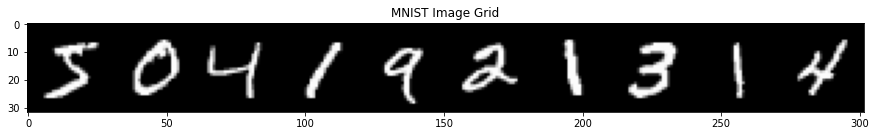

In [8]:
## training Data
trainDataSet,trainDataLoader=getDataSetAndDataLoader(train=True)

##check the length of the training Dataset
print("the length of the training dataset",len(trainDataSet))

##take a batch by iterating on the dataloader
batch=next(iter(trainDataLoader))
MNISTImages=batch["inputs"]["mnistImage"]
MNISTLabels=batch["outputs"]["mnistLabel"]
inputRands=batch["inputs"]["randomNumberTensor"]
sumLabels=batch["outputs"]['sumLabelTensor']


print("Random Numbers 1-hot tensors\n",inputRands, "\nSum Labels=>", sumLabels)
#plot them
plotGridImages(MNISTImages,MNISTLabels)

## Checking the test dataset

the length of the testing dataset 10000
Random Numbers 1-hot tensors
 tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]) 
Sum Labels=> tensor([ 8,  9,  6,  9, 11,  9,  6, 18,  8, 14])
MNIST Labels=> tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


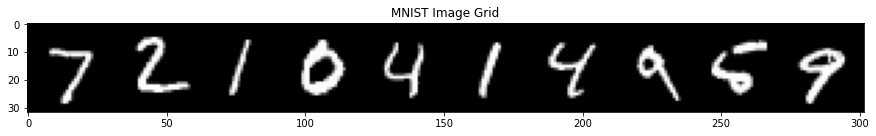

In [9]:
## test Data
testDataSet,testDataLoader=getDataSetAndDataLoader(train=False)

##check the length of the testing Dataset
print("the length of the testing dataset",len(testDataSet))

##take a batch by iterating on the dataloader
batch=next(iter(testDataLoader))
MNISTImages=batch["inputs"]["mnistImage"]
MNISTLabels=batch["outputs"]["mnistLabel"]
inputRands=batch["inputs"]["randomNumberTensor"]
sumLabels=batch["outputs"]['sumLabelTensor']


print("Random Numbers 1-hot tensors\n",inputRands, "\nSum Labels=>", sumLabels)
#plot them
plotGridImages(MNISTImages,MNISTLabels)

## Network Parameters

Lets print to see if the architecture is as per our design or not

In [10]:
network=NetworkMIP()
for name,param in network.named_parameters():
    print(name,'\t\t',param.shape)

conv1.weight 		 torch.Size([6, 1, 5, 5])
conv1.bias 		 torch.Size([6])
conv2.weight 		 torch.Size([12, 6, 5, 5])
conv2.bias 		 torch.Size([12])
fc1.weight 		 torch.Size([120, 192])
fc1.bias 		 torch.Size([120])
fc2.weight 		 torch.Size([20, 10])
fc2.bias 		 torch.Size([20])
fc3.weight 		 torch.Size([100, 140])
fc3.bias 		 torch.Size([100])
out.weight 		 torch.Size([29, 100])
out.bias 		 torch.Size([29])


## Training loop

This is the main workhorse. this is the place where we will train our network using the data coming from dataloader.



The following flowchart summarizes all the steps involved in training

![alt text](../img/training_loop.png "Title")

### Loss Functions

![alt text](../img/loss.png "Title")

There are two losses to be calculated so that they can train on the network for the 2 different outputs. 

1. **Loss_MNIST** will try to train the network so that MNIST labels can be predicted accurately

2. **Loss_Sum** will try to train the network so that Summation Labels can be predicted accurately

Now once the two losses are calculated we combined them since the network as a whole is producing the two losses

 ``` loss_combined=loss_MNIST+loss_sum ```

**Note:** $\Rightarrow$ This is similar to the backprop calculation problem that we did where E=E1+E2 was the total loss



Since we discussed above that both the outputs are classification outputs so we can use a similar loss function which is **cross entropy**  TOCO: why cross-entropy has been used ..so the benefit of it needs to be mentioned

The predictions that we get after calling Forward() will give a 29 bit tensor in which first 10 are for MNIST and next 19 are for summation label

```
MNISTPreds=pred[0:10]
sumPreds=pred[10:19]

loss_MNIST=F.cross_entropy(MNISTPreds,MNISTLabels)
loss_sum=F.cross_entropy(sumPreds,sumLabels)
```


In [11]:
##get the network instance
network=NetworkMIP()

## we want the training to be on GPU 
device='cuda'

##move the network to gpu
network.to(device)


##get the dataset & dataloader
trainDataSet,trainDataLoader=getDataSetAndDataLoader(imagePath="data", ##the MNIST location
                                                     train=True, ## trainign data is requested
                                                     batch_size=256, ## batchsize of 256
                                                     shuffle=True ## shuffle is true
                                                    )


##declare optimizer..we use Adam. 
## the learning rate is 0.01
optimizer=optim.Adam(network.parameters(),lr=0.01)

##number of epoch for which it is running
num_epoch=10


comment=f'Pytorch Assignment-sol'

### create an instance of the summarywriter
tb=SummaryWriter(comment=comment)

## Do this for each epoch
## run the training for each batch of the data
## the following is done for each batch
    ###1. get the batch of trainign data
    ###2. calculate the predictions on the data by passing throght the forward() of the Network
    ###3. Find out MNISTPrediction  and SumPrediction
    ###4. Calculate the cross entropy loss for MNSIT image & cross entropy loss for sumlabel
    ###5. Calculate the total loss which is the sum of Loss_MNIST & Loss_sumlabel
    ###6. Calculate the gradient for all the parameters using the backpropogation 
    ###7  Update the weights of the parameters
    ###8. Keep track of the total loss & accuracy for this batch
## calculate the Loss and the accuracy per epoch using the batch wise loss and accuracy
## Send it to tensorboard for visualization

for epoch in range(num_epoch):
    
    total_correct_MNISTLabels=0
    total_correct_sumLabels=0
    
    total_combined_loss=0
    total_combined_accuracy=0
    
    ##taking batches from data loader
    for batch in trainDataLoader:
        
        MNISTImages=batch["inputs"]["mnistImage"].to(device)
        MNISTLabels=batch["outputs"]["mnistLabel"].to(device)
        inputRands=batch["inputs"]["randomNumberTensor"].to(device)
        sumLabels=batch["outputs"]['sumLabelTensor'].to(device)

        ## the network will take 2 parameters 1. MNIST images 2. random numbers
        ## it generates the predictions of the dimnention (batch,29)
        preds=network(MNISTImages,inputRands)
        
        ## read the first 10 neurons that will contain the output for the MNIST
        MNISTPreds=preds[:,0:10]
        ## the 11-29 will contain the output of the sum
        sumPreds=preds[:,10:]
        
        ## we need to calculate loss 2 times..one for MNISt and other for the sum
        ## also both the losses can be cross entropy because we can treat sum also as a class 
        loss_MNIST=F.cross_entropy(MNISTPreds,MNISTLabels)
        loss_sum=F.cross_entropy(sumPreds,sumLabels)

        ##combine the two losses
        loss_combined=loss_MNIST+loss_sum
        
        ## zero out the gradients before the backprop
        optimizer.zero_grad()

        ## call the backward() to initiate the backpropogation and calculation of gradients
        loss_combined.backward()    
        
        #update the weigths
        optimizer.step()

        ##keep track of the combined loss for the batches
        total_combined_loss+=loss_combined.item()
        
        ##keep track of number of correct predictions for both MNIST and sumLabels
        total_correct_MNISTLabels+=get_num_correct_MNISTLabels(MNISTPreds,MNISTLabels)
        total_correct_sumLabels+=get_num_correct_sumLabels(sumPreds,sumLabels)
        
        
    
    ## total accuracy at the epoch level.. we divide by the length of the dataset to normalize the accuracy
    accuracy_MNISTLabels=total_correct_MNISTLabels/len(trainDataSet)
    accuracy_sumLabels=total_correct_sumLabels/len(trainDataSet)
    
    ##tensor board exports
    tb.add_scalar('Loss',total_combined_loss,epoch)
    tb.add_scalar('Accuracy_MNIST',accuracy_MNISTLabels,epoch)
    tb.add_scalar('Accuracy_Sum',accuracy_sumLabels,epoch)

    
    print("epoch:",epoch,"total_combined_loss",total_combined_loss,"accuracy_MNIST",accuracy_MNISTLabels,"accuracy_sum",accuracy_sumLabels)
  

epoch: 0 total_combined_loss 309.8465375676751 accuracy_MNIST 0.8917833333333334 accuracy_sum 0.6802666666666667
epoch: 1 total_combined_loss 44.314497631043196 accuracy_MNIST 0.97615 accuracy_sum 0.9742333333333333
epoch: 2 total_combined_loss 34.91415202245116 accuracy_MNIST 0.9807666666666667 accuracy_sum 0.9792666666666666
epoch: 3 total_combined_loss 30.390678141266108 accuracy_MNIST 0.9826333333333334 accuracy_sum 0.982
epoch: 4 total_combined_loss 26.76631567813456 accuracy_MNIST 0.9840166666666667 accuracy_sum 0.9834166666666667
epoch: 5 total_combined_loss 24.27411467395723 accuracy_MNIST 0.9866666666666667 accuracy_sum 0.98505
epoch: 6 total_combined_loss 23.52725002821535 accuracy_MNIST 0.9873833333333333 accuracy_sum 0.9853833333333334
epoch: 7 total_combined_loss 20.687381211668253 accuracy_MNIST 0.9887166666666667 accuracy_sum 0.9870666666666666
epoch: 8 total_combined_loss 20.81428661942482 accuracy_MNIST 0.98855 accuracy_sum 0.9873
epoch: 9 total_combined_loss 19.725429

## Evaluation

The custom dataset class is able to give a train dataset and test dataset
MNIST dataset already comes with 60000 training and 10000 test images In the ```_getItem__``` we generate the random number and the Sum Labels 

The Sum labels have also been geenrated accordingly

 * **getDataSetAndDataLoader()** is called to give the testDataSet and testDataLoader by passing **train=False**

### Inference
We use this testing dataset to evaluate the output by calling **forward()** on the trained network.
The inference can be done on CPU also.
Therefore we will not send the network parameters and the test data on the GPU this time. By default device is cpu


### Accuracy 
The network is able to classify both MNSIT labels and Sum Labels at __97% accuracy__
 on test data

The following flowchart summarizes the steps:
![alt text](../img/test_loop.png "Title")

In [12]:
##bring the network parameters back to cpu
network.to('cpu')

##get the dataset & dataloader
testDataSet,testDataLoader=getDataSetAndDataLoader(imagePath="data", ##the MNIST location
                                                     train=False, ## test data is requested
                                                     batch_size=256, ## batchsize of 256
                                                     shuffle=True ## shuffle is true
                                                    )

## will calculate the accuracy on the entire testdata batch by batch
total_correct_MNIST=0
total_correct_sum=0

for batch in testDataLoader:
    MNISTImages=batch["inputs"]["mnistImage"]
    MNISTLabels=batch["outputs"]["mnistLabel"]
    inputRands=batch["inputs"]["randomNumberTensor"]
    sumLabels=batch["outputs"]['sumLabelTensor']

    ##get the predictions
    preds=network(MNISTImages,inputRands)

    ## read the first 10 neurons that will contain the output for the MNIST
    MNISTPreds=preds[:,0:10]
    ## the 11-29 will contain the output of the sum
    sumPreds=preds[:,10:]
    
     ## also both the losses can be cross entropy because we can treat sum also as a class 
    loss_MNIST=F.cross_entropy(MNISTPreds,MNISTLabels)
    loss_sum=F.cross_entropy(sumPreds,sumLabels)

    ##combine the two losses
    loss_combined=loss_MNIST+loss_sum
    
    
    ##keep track of number of correct predictions for both MNIST and sumLabels
    total_correct_MNIST+=get_num_correct_MNISTLabels(MNISTPreds,MNISTLabels)
    total_correct_sum+=get_num_correct_sumLabels(sumPreds,sumLabels)
      
## Final accuracy we divide by the length of the dataset to normalize the accuracy
accuracy_MNIST=total_correct_MNIST/len(testDataSet)
accuracy_sum=total_correct_sum/len(testDataSet)
print("total loss on test data",loss_combined)
print("total test accuracy on MNIST",accuracy_MNIST)
print("total test accuracy on SumLabels",accuracy_sum)

total loss on test data tensor(0.0007, grad_fn=<AddBackward0>)
total test accuracy on MNIST 0.9815
total test accuracy on SumLabels 0.98
